# Regression with RNNs 5

## What's new?
1. Train a LSTM network to predict sin(t) using cos(t).
2. Manually implement a recurrent network by inherenting the `nn.Module` class; without using the `nn.LSTM` module. This gives us the maximal flexibility. We need to push the data into the network time-step by time-step. Can't feed a batch of data like using the `nn.LSTM` module.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


# This shows good pic: format from classic style; color and style from seaborn
plt.style.use('classic')
plt.style.use('seaborn')


# Hyper-Parameters
TIME_STEP = 20      # mini-batch size
SKIP = 10           # skip some time-steps to prepare hidden state in mini-batch training

INPUT_SIZE = 1      # rnn input size
HIDDEN_SIZE = 16    # rnn hidden size
OUTPUT_SIZE = 1     # rnn output size

LR = 1e-2           # learning rate

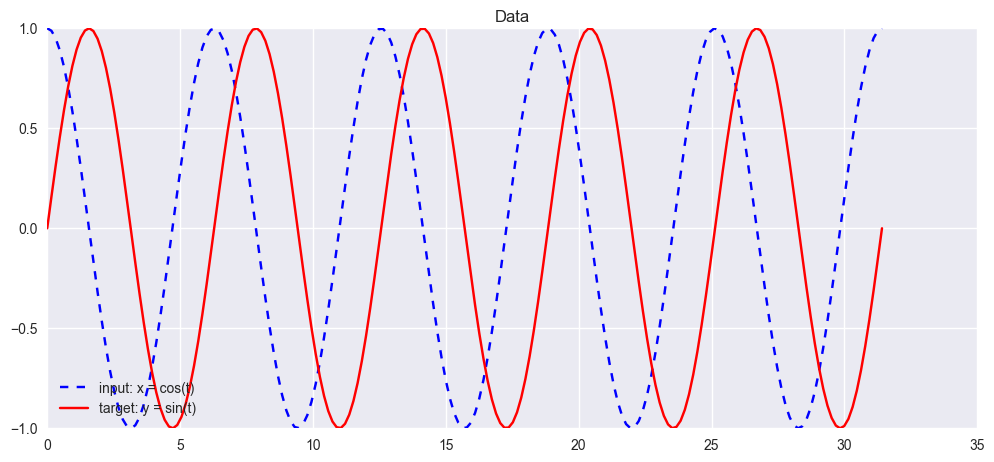

In [2]:
# Generate data: train a RNN to input cos(t) to predict sin(t)
# Note the np.float32 datatype for torch.FloatTensor
steps = np.linspace(0, 10* np.pi, 200, dtype=np.float32)[:, np.newaxis]  # time steps
X_np = np.cos(steps)
y_np = np.sin(steps)

N = len(X_np)

# Plot data
plt.figure(1, figsize=(12, 5))
plt.plot(steps, X_np, 'b', linestyle='dashed', label='input: x = cos(t)')
plt.plot(steps, y_np, 'r', label='target: y = sin(t)')
plt.legend(loc='lower left')
plt.title('Data')
plt.show()

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        Note: 
            in PyTorch implementation of nn.LSTM... concat... two layers of size *4...
        """
        
        super(LSTM, self).__init__()
        
        # Input gate
        self._ii = nn.Linear(input_size, hidden_size)
        self._hi = nn.Linear(hidden_size, hidden_size)
        
        # Forget gate
        self._if = nn.Linear(input_size, hidden_size)
        self._hf = nn.Linear(hidden_size, hidden_size)
        
        # Cell gate
        self._ic = nn.Linear(input_size, hidden_size)
        self._hc = nn.Linear(hidden_size, hidden_size)
        
        # Output gate
        self._io = nn.Linear(input_size, hidden_size)
        self._ho = nn.Linear(hidden_size, hidden_size)
        
        # Output
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, last_hidden, last_cell):
        
        i = F.sigmoid(self._ii(x) + self._hi(last_hidden))
        f = F.sigmoid(self._if(x) + self._hf(last_hidden))
        g = F.tanh(self._ic(x) + self._hc(last_hidden))
        o = F.sigmoid(self._io(x) + self._ho(last_hidden))
        
        cell = f.mul(last_cell) + i.mul(g)
        hidden = o.mul(F.tanh(cell))
        
        output = self.out(hidden)
        
        return output, hidden, cell

In [4]:
# Model
lstm = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

# Optimizer
optim = torch.optim.Adam(lstm.parameters(), lr=LR)

# Loss function
loss_fn = nn.MSELoss()

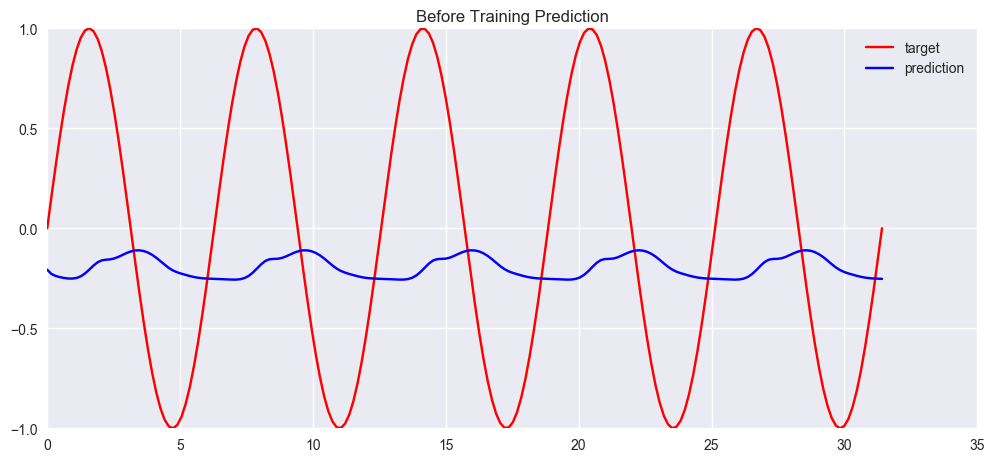

In [5]:
"""
Before training, the RNN ouptuts the curve like this...
"""

plt.figure(1, figsize=(12, 5))


# Plot after all training completes
pred_lst = []

# Initialize hidden and cell state
hidden = Variable(torch.zeros(1, HIDDEN_SIZE))
cell = Variable(torch.zeros(1, HIDDEN_SIZE))

for t in range(N):
    x = Variable(torch.from_numpy(X_np[t:t+1, :]))
    
    predict, hidden, cell = lstm(x, hidden, cell)
    pred_lst.append(predict.data[0][0])
    
    
plt.title('Before Training Prediction')
plt.plot(steps, y_np.flatten(), 'r', label='target')
plt.plot(steps, np.array(pred_lst), 'b', label='prediction')
plt.legend(loc='best')

plt.show()

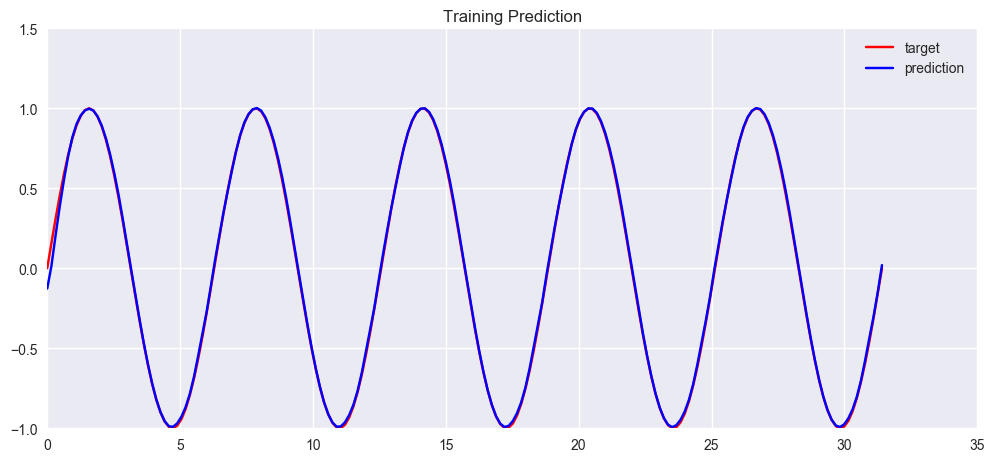

In [6]:
# Train for __ epochs, an epoch means that every data point should be picked once in expectation   
for epoch in range(200):
    
    for iteration in range(int(N/TIME_STEP)):
        
        # Pick start index in the dataset to create a mini-batch. Consider sequences of length TIME_STEP+SKIP.
        
        """
        *Trick* it would be problematic to always start training with empty hidden state, so we sample a longer
                sequence (TIME_STEP + SKIP); perform a complete forward pass but only backprop for TIME_STEP many
                steps.
        """
        start = np.random.randint(N)
        prestart = max(start - SKIP, 0)
        end = min(start + TIME_STEP, 200)
        
        
        # Extract mini-batch
        trainX = X_np[prestart:end, :]
        trainY = y_np[prestart:end, :]
        
        
        # Initialize hidden, cell state for each mini-batch of training
        hidden = Variable(torch.zeros(1, HIDDEN_SIZE))
        cell = Variable(torch.zeros(1, HIDDEN_SIZE))
        
        
        # Forward pass and loss compute
        Loss = 0
        for t in range(len(trainX)):  # note it may be less that TIME_STEP+SKIP many time-steps

            x = Variable(torch.from_numpy(trainX[t:t+1, :]))
            y = Variable(torch.from_numpy(trainY[t:t+1, :]))

            predict, hidden, cell = lstm(x, hidden, cell)

            # Skip the first SKIP many time-steps for the reason stated above.
            if t < start - prestart: continue
            
            
            loss = loss_fn(predict, y)
            Loss += loss
            

        # Backward pass and param update
        optim.zero_grad()
        Loss.backward(retain_variables=True)
        optim.step()
        
        
"""
Training Evaluation
"""        

plt.figure(1, figsize=(12, 5))


# Plot after all training completes
pred_lst = []

# Initialize hidden and cell state
hidden = Variable(torch.zeros(1, HIDDEN_SIZE))
cell = Variable(torch.zeros(1, HIDDEN_SIZE))

for t in range(N):
    x = Variable(torch.from_numpy(X_np[t:t+1, :]))
    
    predict, hidden, cell = lstm(x, hidden, cell)
    pred_lst.append(predict.data[0][0])
    
    
plt.title('Training Prediction')
plt.plot(steps, y_np.flatten(), 'r', label='target')
plt.plot(steps, np.array(pred_lst), 'b', label='prediction')
plt.legend(loc='best')

plt.show()